In [2]:
import numpy as np
import librosa
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt
from matplotlib import cm
import os
import soundfile as sf
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler



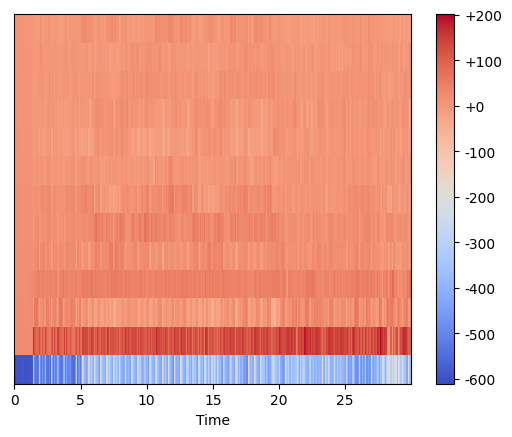

In [17]:
# Create plot
song1 = '/content/drive/MyDrive/dataset/training/georgian-disco/out1000.mp3'
song2 = '/content/drive/MyDrive/dataset/training/georgian-disco/out2000.mp3'
song3 = '/content/drive/MyDrive/dataset/training/somebody-i-used-to-know/out000.mp3'
y1,sr1 = librosa.load(song1)
y2,sr2 = librosa.load(song2)
y3,sr3 = librosa.load(song3)
# Plot waveforms
#librosa.display.waveshow(y=y1,sr=sr1)
#librosa.display.waveshow(y=y2,sr=sr2)
#librosa.display.waveshow(y=y3,sr=sr3)

# plot spectrogram
FRAME_SIZE = 2048
HOP_SIZE = 512

#y1_stft = librosa.stft(y1,n_fft=FRAME_SIZE,hop_length=HOP_SIZE)
#y1_spect = np.abs(y1_stft)**2

#y2_stft = librosa.stft(y2,n_fft=FRAME_SIZE,hop_length=HOP_SIZE)
#y2_spect = np.abs(y2_stft)**2

#y3_stft = librosa.stft(y3,n_fft=FRAME_SIZE,hop_length=HOP_SIZE)
#y3_spect = np.abs(y3_stft)**2


#librosa.display.specshow(y3_spect,sr=sr3,hop_length=HOP_SIZE,x_axis="time",y_axis="log")
#plt.colorbar(format='%+2.f')

# plot mfccs
#mfcc1 = librosa.feature.mfcc(y=y1,n_mfcc=13,sr=sr1)
#mfcc2 = librosa.feature.mfcc(y=y2,n_mfcc=13,sr=sr2)
mfcc3 = librosa.feature.mfcc(y=y3,n_mfcc=13,sr=sr3)

librosa.display.specshow(mfcc3,x_axis="time",sr=sr3)
plt.colorbar(format='%+2.f')


In [34]:
count = 0
inputs = np.zeros((172,15236))
labels = []
k = 0
label_map = {}
base_path = '/content/drive/MyDrive/dataset/training/' # 'dataset/training/'
for song_folder in os.listdir(base_path):
    # song_folder will be used as class name/label
    for song in os.listdir(base_path+song_folder+'/'):
        song_path = base_path+song_folder+'/'+song
        signal,sr = librosa.load(song_path)
        signal = np.resize(signal,600000)
        print(song_path)
        mfcc = librosa.feature.mfcc(y=signal,n_mfcc=13,sr=sr)
        inputs[count] = mfcc.flatten()
        labels.append(k)
        label_map[song_folder] = k
        count+=1
    k += 1
print(count)

/content/drive/MyDrive/dataset/training/georgian-disco/out1004.mp3
/content/drive/MyDrive/dataset/training/georgian-disco/out3005.mp3
/content/drive/MyDrive/dataset/training/georgian-disco/out4003.mp3
/content/drive/MyDrive/dataset/training/georgian-disco/out3002.mp3
/content/drive/MyDrive/dataset/training/georgian-disco/out5002.mp3
/content/drive/MyDrive/dataset/training/georgian-disco/out2001.mp3
/content/drive/MyDrive/dataset/training/georgian-disco/out3003.mp3
/content/drive/MyDrive/dataset/training/georgian-disco/out5000.mp3
/content/drive/MyDrive/dataset/training/georgian-disco/out1000.mp3
/content/drive/MyDrive/dataset/training/georgian-disco/out2003.mp3
/content/drive/MyDrive/dataset/training/georgian-disco/out3000.mp3
/content/drive/MyDrive/dataset/training/georgian-disco/out4000.mp3
/content/drive/MyDrive/dataset/training/georgian-disco/out3001.mp3
/content/drive/MyDrive/dataset/training/georgian-disco/out5001.mp3
/content/drive/MyDrive/dataset/training/georgian-disco/out2000

In [35]:
print(count)
print(inputs.shape)
labels = np.array(labels)
print(labels)

172
(172, 15236)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]


In [36]:
model = Sequential([
        Input(shape=(inputs.shape[1],)), #creates input layer, no of nodes = no of inputs = 179
        Dense(256, activation='relu'), #1st hidden layer with 256 neurons
        BatchNormalization(), #normalize the output value so that input to next layer is normalized
        # Dropout(0.3), #this is to prevent overfitting but my results are way better without it atm so fk dis - will use if i have problems on test data
        Dense(128, activation='relu'),
        BatchNormalization(),
        # Dropout(0.3),
        Dense(64, activation='relu'),
        BatchNormalization(),
        # Dropout(0.3),
        Dense(len(np.unique(labels)), activation='softmax')
    ])

In [37]:
# Define learning rate scheduler
def lr_scheduler(epoch, lr):
    if epoch % 10 == 0 and epoch != 0:
        lr = lr * 0.9 # decreases the learning rate by a factor of 0.9 every 10 epochs - prevent over stepping
    return lr

# Implement learning rate scheduler
lr_scheduler_callback = LearningRateScheduler(lr_scheduler)

In [38]:
# Implement early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10, #if 'val_loss' does not improve in 10 iterations then stop
    restore_best_weights=True # use best found weights
)

In [39]:
# Compile the model
model.compile(loss='sparse_categorical_crossentropy',#use 0/1 (fancy name sem thing)
              optimizer=Adam(), # adam optimizer - instead of sgd for classification - sgd is better for regression
              metrics=['accuracy']) , # print accuracy after fixed interval

(None,)

In [40]:
# Train the model
history = model.fit(inputs, # inputs
                    labels, # expected outputs
                    epochs=100, # max number of times to traverse over training data for learning
                    batch_size=32, # give inputs in batches of 32 - why u ask? - see this link: https://youtu.be/TEWy9vZcxW4?list=PLQVvvaa0QuDcjD5BAw2DxE6OF2tius3V3&t=302
                    callbacks=[early_stopping, lr_scheduler_callback]) # integrates functions upar wle into our training

Epoch 1/100
6/6 [==============================] - ETA: 0s - loss: 1.7649 - accuracy: 0.3895

6/6 [==============================] - 3s 95ms/step - loss: 1.7649 - accuracy: 0.3895 - lr: 0.0010
Epoch 2/100
6/6 [==============================] - ETA: 0s - loss: 0.6880 - accuracy: 0.8198

6/6 [==============================] - 1s 119ms/step - loss: 0.6880 - accuracy: 0.8198 - lr: 0.0010
Epoch 3/100
6/6 [==============================] - ETA: 0s - loss: 0.4489 - accuracy: 0.9128

6/6 [==============================] - 1s 90ms/step - loss: 0.4489 - accuracy: 0.9128 - lr: 0.0010
Epoch 4/100
6/6 [==============================] - ETA: 0s - loss: 0.3175 - accuracy: 0.9709

6/6 [==============================] - 0s 75ms/step - loss: 0.3175 - accuracy: 0.9709 - lr: 0.0010
Epoch 5/100
6/6 [==============================] - ETA: 0s - loss: 0.2159 - accuracy: 0.9942

6/6 [==============================] - 0s 78ms/step - loss: 0.2159 - accuracy: 0.9942 - lr: 0.0010
Epoch 6/100
6/6 [==============================] - ETA: 0s - loss: 0.1485 - accuracy: 0.9942

6/6 [==============================] - 0s 70ms/step - loss: 0.1485 - accuracy: 0.9942 - lr: 0.0010
Epoch 7/100
6/6 [==============================] - ETA: 0s - loss: 0.1130 - accuracy: 1.0000

6/6 [==============================] - 1s 112ms/step - loss: 0.1130 - accuracy: 1.0000 - lr: 0.0010
Epoch 8/100
6/6 [==============================] - ETA: 0s - loss: 0.1604 - accuracy: 0.9826

6/6 [==============================] - 1s 109ms/step - loss: 0.1604 - accuracy: 0.9826 - lr: 0.0010
Epoch 9/100
6/6 [==============================] - ETA: 0s - loss: 0.0777 - accuracy: 0.9942

6/6 [==============================] - 0s 60ms/step - loss: 0.0777 - accuracy: 0.9942 - lr: 0.0010
Epoch 10/100
6/6 [==============================] - ETA: 0s - loss: 0.0772 - accuracy: 0.9942

6/6 [==============================] - 0s 49ms/step - loss: 0.0772 - accuracy: 0.9942 - lr: 0.0010
Epoch 11/100
6/6 [==============================] - ETA: 0s - loss: 0.0672 - accuracy: 1.0000

6/6 [==============================] - 0s 64ms/step - loss: 0.0672 - accuracy: 1.0000 - lr: 9.0000e-04
Epoch 12/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0636 - accuracy: 1.0000

6/6 [==============================] - 0s 57ms/step - loss: 0.0616 - accuracy: 1.0000 - lr: 9.0000e-04
Epoch 13/100
6/6 [==============================] - ETA: 0s - loss: 0.0442 - accuracy: 1.0000

6/6 [==============================] - 0s 67ms/step - loss: 0.0442 - accuracy: 1.0000 - lr: 9.0000e-04
Epoch 14/100
6/6 [==============================] - ETA: 0s - loss: 0.0495 - accuracy: 1.0000

6/6 [==============================] - 0s 64ms/step - loss: 0.0495 - accuracy: 1.0000 - lr: 9.0000e-04
Epoch 15/100
6/6 [==============================] - ETA: 0s - loss: 0.0459 - accuracy: 1.0000

6/6 [==============================] - 0s 71ms/step - loss: 0.0459 - accuracy: 1.0000 - lr: 9.0000e-04
Epoch 16/100
6/6 [==============================] - ETA: 0s - loss: 0.0266 - accuracy: 1.0000

6/6 [==============================] - 0s 78ms/step - loss: 0.0266 - accuracy: 1.0000 - lr: 9.0000e-04
Epoch 17/100
6/6 [==============================] - ETA: 0s - loss: 0.0275 - accuracy: 1.0000

6/6 [==============================] - 0s 80ms/step - loss: 0.0275 - accuracy: 1.0000 - lr: 9.0000e-04
Epoch 18/100
6/6 [==============================] - ETA: 0s - loss: 0.0247 - accuracy: 1.0000

6/6 [==============================] - 0s 64ms/step - loss: 0.0247 - accuracy: 1.0000 - lr: 9.0000e-04
Epoch 19/100
6/6 [==============================] - ETA: 0s - loss: 0.0251 - accuracy: 1.0000

6/6 [==============================] - 0s 48ms/step - loss: 0.0251 - accuracy: 1.0000 - lr: 9.0000e-04
Epoch 20/100
6/6 [==============================] - ETA: 0s - loss: 0.0192 - accuracy: 1.0000

6/6 [==============================] - 0s 55ms/step - loss: 0.0192 - accuracy: 1.0000 - lr: 9.0000e-04
Epoch 21/100
6/6 [==============================] - ETA: 0s - loss: 0.0222 - accuracy: 1.0000

6/6 [==============================] - 0s 53ms/step - loss: 0.0222 - accuracy: 1.0000 - lr: 8.1000e-04
Epoch 22/100
6/6 [==============================] - ETA: 0s - loss: 0.0254 - accuracy: 0.9942

6/6 [==============================] - 0s 68ms/step - loss: 0.0254 - accuracy: 0.9942 - lr: 8.1000e-04
Epoch 23/100
6/6 [==============================] - ETA: 0s - loss: 0.0314 - accuracy: 1.0000

6/6 [==============================] - 0s 69ms/step - loss: 0.0314 - accuracy: 1.0000 - lr: 8.1000e-04
Epoch 24/100
6/6 [==============================] - ETA: 0s - loss: 0.0336 - accuracy: 1.0000

6/6 [==============================] - 1s 82ms/step - loss: 0.0336 - accuracy: 1.0000 - lr: 8.1000e-04
Epoch 25/100
6/6 [==============================] - ETA: 0s - loss: 0.0317 - accuracy: 1.0000

6/6 [==============================] - 0s 81ms/step - loss: 0.0317 - accuracy: 1.0000 - lr: 8.1000e-04
Epoch 26/100
6/6 [==============================] - ETA: 0s - loss: 0.0336 - accuracy: 0.9942

6/6 [==============================] - 0s 87ms/step - loss: 0.0336 - accuracy: 0.9942 - lr: 8.1000e-04
Epoch 27/100
6/6 [==============================] - ETA: 0s - loss: 0.0229 - accuracy: 1.0000

6/6 [==============================] - 1s 114ms/step - loss: 0.0229 - accuracy: 1.0000 - lr: 8.1000e-04
Epoch 28/100
6/6 [==============================] - ETA: 0s - loss: 0.0222 - accuracy: 1.0000

6/6 [==============================] - 0s 73ms/step - loss: 0.0222 - accuracy: 1.0000 - lr: 8.1000e-04
Epoch 29/100
6/6 [==============================] - ETA: 0s - loss: 0.0134 - accuracy: 1.0000

6/6 [==============================] - 1s 98ms/step - loss: 0.0134 - accuracy: 1.0000 - lr: 8.1000e-04
Epoch 30/100
6/6 [==============================] - ETA: 0s - loss: 0.0174 - accuracy: 1.0000

6/6 [==============================] - 1s 112ms/step - loss: 0.0174 - accuracy: 1.0000 - lr: 8.1000e-04
Epoch 31/100
6/6 [==============================] - ETA: 0s - loss: 0.0140 - accuracy: 1.0000

6/6 [==============================] - 1s 92ms/step - loss: 0.0140 - accuracy: 1.0000 - lr: 7.2900e-04
Epoch 32/100
6/6 [==============================] - ETA: 0s - loss: 0.0125 - accuracy: 1.0000

6/6 [==============================] - 1s 110ms/step - loss: 0.0125 - accuracy: 1.0000 - lr: 7.2900e-04
Epoch 33/100
6/6 [==============================] - ETA: 0s - loss: 0.0101 - accuracy: 1.0000

6/6 [==============================] - 1s 106ms/step - loss: 0.0101 - accuracy: 1.0000 - lr: 7.2900e-04
Epoch 34/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0125 - accuracy: 1.0000

6/6 [==============================] - 0s 60ms/step - loss: 0.0159 - accuracy: 1.0000 - lr: 7.2900e-04
Epoch 35/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0113 - accuracy: 1.0000

6/6 [==============================] - 0s 48ms/step - loss: 0.0145 - accuracy: 1.0000 - lr: 7.2900e-04
Epoch 36/100
6/6 [==============================] - ETA: 0s - loss: 0.0132 - accuracy: 1.0000

6/6 [==============================] - 0s 68ms/step - loss: 0.0132 - accuracy: 1.0000 - lr: 7.2900e-04
Epoch 37/100
6/6 [==============================] - ETA: 0s - loss: 0.0094 - accuracy: 1.0000

6/6 [==============================] - 0s 68ms/step - loss: 0.0094 - accuracy: 1.0000 - lr: 7.2900e-04
Epoch 38/100
6/6 [==============================] - ETA: 0s - loss: 0.0089 - accuracy: 1.0000

6/6 [==============================] - 0s 61ms/step - loss: 0.0089 - accuracy: 1.0000 - lr: 7.2900e-04
Epoch 39/100
6/6 [==============================] - ETA: 0s - loss: 0.0183 - accuracy: 0.9942

6/6 [==============================] - 0s 65ms/step - loss: 0.0183 - accuracy: 0.9942 - lr: 7.2900e-04
Epoch 40/100
6/6 [==============================] - ETA: 0s - loss: 0.0070 - accuracy: 1.0000

6/6 [==============================] - 0s 67ms/step - loss: 0.0070 - accuracy: 1.0000 - lr: 7.2900e-04
Epoch 41/100
6/6 [==============================] - ETA: 0s - loss: 0.0097 - accuracy: 1.0000

6/6 [==============================] - 0s 62ms/step - loss: 0.0097 - accuracy: 1.0000 - lr: 6.5610e-04
Epoch 42/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0113 - accuracy: 1.0000

6/6 [==============================] - 0s 58ms/step - loss: 0.0120 - accuracy: 1.0000 - lr: 6.5610e-04
Epoch 43/100
6/6 [==============================] - ETA: 0s - loss: 0.0108 - accuracy: 1.0000

6/6 [==============================] - 0s 62ms/step - loss: 0.0108 - accuracy: 1.0000 - lr: 6.5610e-04
Epoch 44/100
6/6 [==============================] - ETA: 0s - loss: 0.0079 - accuracy: 1.0000

6/6 [==============================] - 0s 57ms/step - loss: 0.0079 - accuracy: 1.0000 - lr: 6.5610e-04
Epoch 45/100
6/6 [==============================] - ETA: 0s - loss: 0.0079 - accuracy: 1.0000

6/6 [==============================] - 0s 62ms/step - loss: 0.0079 - accuracy: 1.0000 - lr: 6.5610e-04
Epoch 46/100
6/6 [==============================] - ETA: 0s - loss: 0.0094 - accuracy: 1.0000

6/6 [==============================] - 0s 66ms/step - loss: 0.0094 - accuracy: 1.0000 - lr: 6.5610e-04
Epoch 47/100
6/6 [==============================] - ETA: 0s - loss: 0.0077 - accuracy: 1.0000

6/6 [==============================] - 0s 54ms/step - loss: 0.0077 - accuracy: 1.0000 - lr: 6.5610e-04
Epoch 48/100
6/6 [==============================] - ETA: 0s - loss: 0.0238 - accuracy: 0.9942

6/6 [==============================] - 0s 58ms/step - loss: 0.0238 - accuracy: 0.9942 - lr: 6.5610e-04
Epoch 49/100
6/6 [==============================] - ETA: 0s - loss: 0.0274 - accuracy: 0.9942

6/6 [==============================] - 0s 69ms/step - loss: 0.0274 - accuracy: 0.9942 - lr: 6.5610e-04
Epoch 50/100
6/6 [==============================] - ETA: 0s - loss: 0.0336 - accuracy: 0.9942

6/6 [==============================] - 0s 62ms/step - loss: 0.0336 - accuracy: 0.9942 - lr: 6.5610e-04
Epoch 51/100
6/6 [==============================] - ETA: 0s - loss: 0.0136 - accuracy: 1.0000

6/6 [==============================] - 0s 53ms/step - loss: 0.0136 - accuracy: 1.0000 - lr: 5.9049e-04
Epoch 52/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0150 - accuracy: 1.0000

6/6 [==============================] - 0s 58ms/step - loss: 0.0155 - accuracy: 1.0000 - lr: 5.9049e-04
Epoch 53/100
6/6 [==============================] - ETA: 0s - loss: 0.0123 - accuracy: 1.0000

6/6 [==============================] - 0s 59ms/step - loss: 0.0123 - accuracy: 1.0000 - lr: 5.9049e-04
Epoch 54/100
6/6 [==============================] - ETA: 0s - loss: 0.0094 - accuracy: 1.0000

6/6 [==============================] - 0s 60ms/step - loss: 0.0094 - accuracy: 1.0000 - lr: 5.9049e-04
Epoch 55/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0091 - accuracy: 1.0000

6/6 [==============================] - 0s 46ms/step - loss: 0.0136 - accuracy: 1.0000 - lr: 5.9049e-04
Epoch 56/100
6/6 [==============================] - ETA: 0s - loss: 0.0073 - accuracy: 1.0000

6/6 [==============================] - 0s 59ms/step - loss: 0.0073 - accuracy: 1.0000 - lr: 5.9049e-04
Epoch 57/100
6/6 [==============================] - ETA: 0s - loss: 0.0073 - accuracy: 1.0000

6/6 [==============================] - 0s 71ms/step - loss: 0.0073 - accuracy: 1.0000 - lr: 5.9049e-04
Epoch 58/100
6/6 [==============================] - ETA: 0s - loss: 0.0068 - accuracy: 1.0000

6/6 [==============================] - 0s 65ms/step - loss: 0.0068 - accuracy: 1.0000 - lr: 5.9049e-04
Epoch 59/100
6/6 [==============================] - ETA: 0s - loss: 0.0066 - accuracy: 1.0000

6/6 [==============================] - 0s 85ms/step - loss: 0.0066 - accuracy: 1.0000 - lr: 5.9049e-04
Epoch 60/100
6/6 [==============================] - ETA: 0s - loss: 0.0062 - accuracy: 1.0000

6/6 [==============================] - 1s 106ms/step - loss: 0.0062 - accuracy: 1.0000 - lr: 5.9049e-04
Epoch 61/100
6/6 [==============================] - ETA: 0s - loss: 0.0065 - accuracy: 1.0000

6/6 [==============================] - 1s 106ms/step - loss: 0.0065 - accuracy: 1.0000 - lr: 5.3144e-04
Epoch 62/100
6/6 [==============================] - ETA: 0s - loss: 0.0046 - accuracy: 1.0000

6/6 [==============================] - 1s 126ms/step - loss: 0.0046 - accuracy: 1.0000 - lr: 5.3144e-04
Epoch 63/100
6/6 [==============================] - ETA: 0s - loss: 0.0058 - accuracy: 1.0000

6/6 [==============================] - 1s 130ms/step - loss: 0.0058 - accuracy: 1.0000 - lr: 5.3144e-04
Epoch 64/100
6/6 [==============================] - ETA: 0s - loss: 0.0039 - accuracy: 1.0000

6/6 [==============================] - 1s 92ms/step - loss: 0.0039 - accuracy: 1.0000 - lr: 5.3144e-04
Epoch 65/100
6/6 [==============================] - ETA: 0s - loss: 0.0046 - accuracy: 1.0000

6/6 [==============================] - 1s 114ms/step - loss: 0.0046 - accuracy: 1.0000 - lr: 5.3144e-04
Epoch 66/100
6/6 [==============================] - ETA: 0s - loss: 0.0039 - accuracy: 1.0000

6/6 [==============================] - 1s 102ms/step - loss: 0.0039 - accuracy: 1.0000 - lr: 5.3144e-04
Epoch 67/100
6/6 [==============================] - ETA: 0s - loss: 0.0049 - accuracy: 1.0000

6/6 [==============================] - 1s 107ms/step - loss: 0.0049 - accuracy: 1.0000 - lr: 5.3144e-04
Epoch 68/100
6/6 [==============================] - ETA: 0s - loss: 0.0045 - accuracy: 1.0000

6/6 [==============================] - 1s 108ms/step - loss: 0.0045 - accuracy: 1.0000 - lr: 5.3144e-04
Epoch 69/100
6/6 [==============================] - ETA: 0s - loss: 0.0035 - accuracy: 1.0000

6/6 [==============================] - 1s 107ms/step - loss: 0.0035 - accuracy: 1.0000 - lr: 5.3144e-04
Epoch 70/100
6/6 [==============================] - ETA: 0s - loss: 0.0028 - accuracy: 1.0000

6/6 [==============================] - 1s 102ms/step - loss: 0.0028 - accuracy: 1.0000 - lr: 5.3144e-04
Epoch 71/100
6/6 [==============================] - ETA: 0s - loss: 0.0030 - accuracy: 1.0000

6/6 [==============================] - 1s 107ms/step - loss: 0.0030 - accuracy: 1.0000 - lr: 4.7830e-04
Epoch 72/100
6/6 [==============================] - ETA: 0s - loss: 0.0037 - accuracy: 1.0000

6/6 [==============================] - 0s 54ms/step - loss: 0.0037 - accuracy: 1.0000 - lr: 4.7830e-04
Epoch 73/100
6/6 [==============================] - ETA: 0s - loss: 0.0039 - accuracy: 1.0000

6/6 [==============================] - 0s 57ms/step - loss: 0.0039 - accuracy: 1.0000 - lr: 4.7830e-04
Epoch 74/100
6/6 [==============================] - ETA: 0s - loss: 0.0059 - accuracy: 1.0000

6/6 [==============================] - 0s 58ms/step - loss: 0.0059 - accuracy: 1.0000 - lr: 4.7830e-04
Epoch 75/100
6/6 [==============================] - ETA: 0s - loss: 0.0038 - accuracy: 1.0000

6/6 [==============================] - 0s 62ms/step - loss: 0.0038 - accuracy: 1.0000 - lr: 4.7830e-04
Epoch 76/100
6/6 [==============================] - ETA: 0s - loss: 0.0035 - accuracy: 1.0000

6/6 [==============================] - 0s 64ms/step - loss: 0.0035 - accuracy: 1.0000 - lr: 4.7830e-04
Epoch 77/100
6/6 [==============================] - ETA: 0s - loss: 0.0059 - accuracy: 1.0000

6/6 [==============================] - 0s 71ms/step - loss: 0.0059 - accuracy: 1.0000 - lr: 4.7830e-04
Epoch 78/100
6/6 [==============================] - ETA: 0s - loss: 0.0037 - accuracy: 1.0000

6/6 [==============================] - 1s 84ms/step - loss: 0.0037 - accuracy: 1.0000 - lr: 4.7830e-04
Epoch 79/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0036 - accuracy: 1.0000

6/6 [==============================] - 0s 49ms/step - loss: 0.0043 - accuracy: 1.0000 - lr: 4.7830e-04
Epoch 80/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0026 - accuracy: 1.0000

6/6 [==============================] - 0s 59ms/step - loss: 0.0055 - accuracy: 1.0000 - lr: 4.7830e-04
Epoch 81/100
6/6 [==============================] - ETA: 0s - loss: 0.0029 - accuracy: 1.0000

6/6 [==============================] - 0s 67ms/step - loss: 0.0029 - accuracy: 1.0000 - lr: 4.3047e-04
Epoch 82/100
6/6 [==============================] - ETA: 0s - loss: 0.0044 - accuracy: 1.0000

6/6 [==============================] - 0s 70ms/step - loss: 0.0044 - accuracy: 1.0000 - lr: 4.3047e-04
Epoch 83/100
6/6 [==============================] - ETA: 0s - loss: 0.0041 - accuracy: 1.0000

6/6 [==============================] - 0s 72ms/step - loss: 0.0041 - accuracy: 1.0000 - lr: 4.3047e-04
Epoch 84/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0025 - accuracy: 1.0000

6/6 [==============================] - 0s 58ms/step - loss: 0.0026 - accuracy: 1.0000 - lr: 4.3047e-04
Epoch 85/100
6/6 [==============================] - ETA: 0s - loss: 0.0039 - accuracy: 1.0000

6/6 [==============================] - 0s 54ms/step - loss: 0.0039 - accuracy: 1.0000 - lr: 4.3047e-04
Epoch 86/100
6/6 [==============================] - ETA: 0s - loss: 0.0075 - accuracy: 1.0000

6/6 [==============================] - 0s 56ms/step - loss: 0.0075 - accuracy: 1.0000 - lr: 4.3047e-04
Epoch 87/100
6/6 [==============================] - ETA: 0s - loss: 0.0044 - accuracy: 1.0000

6/6 [==============================] - 0s 79ms/step - loss: 0.0044 - accuracy: 1.0000 - lr: 4.3047e-04
Epoch 88/100
6/6 [==============================] - ETA: 0s - loss: 0.0032 - accuracy: 1.0000

6/6 [==============================] - 0s 80ms/step - loss: 0.0032 - accuracy: 1.0000 - lr: 4.3047e-04
Epoch 89/100
6/6 [==============================] - ETA: 0s - loss: 0.0030 - accuracy: 1.0000

6/6 [==============================] - 0s 70ms/step - loss: 0.0030 - accuracy: 1.0000 - lr: 4.3047e-04
Epoch 90/100
6/6 [==============================] - ETA: 0s - loss: 0.0035 - accuracy: 1.0000

6/6 [==============================] - 0s 66ms/step - loss: 0.0035 - accuracy: 1.0000 - lr: 4.3047e-04
Epoch 91/100
6/6 [==============================] - ETA: 0s - loss: 0.0035 - accuracy: 1.0000

6/6 [==============================] - 0s 63ms/step - loss: 0.0035 - accuracy: 1.0000 - lr: 3.8742e-04
Epoch 92/100
6/6 [==============================] - ETA: 0s - loss: 0.0036 - accuracy: 1.0000

6/6 [==============================] - 0s 64ms/step - loss: 0.0036 - accuracy: 1.0000 - lr: 3.8742e-04
Epoch 93/100
6/6 [==============================] - ETA: 0s - loss: 0.0040 - accuracy: 1.0000

6/6 [==============================] - 0s 68ms/step - loss: 0.0040 - accuracy: 1.0000 - lr: 3.8742e-04
Epoch 94/100
6/6 [==============================] - ETA: 0s - loss: 0.0113 - accuracy: 1.0000

6/6 [==============================] - 0s 63ms/step - loss: 0.0113 - accuracy: 1.0000 - lr: 3.8742e-04
Epoch 95/100
6/6 [==============================] - ETA: 0s - loss: 0.0069 - accuracy: 1.0000

6/6 [==============================] - 0s 74ms/step - loss: 0.0069 - accuracy: 1.0000 - lr: 3.8742e-04
Epoch 96/100
6/6 [==============================] - ETA: 0s - loss: 0.0060 - accuracy: 1.0000

6/6 [==============================] - 1s 92ms/step - loss: 0.0060 - accuracy: 1.0000 - lr: 3.8742e-04
Epoch 97/100
6/6 [==============================] - ETA: 0s - loss: 0.0060 - accuracy: 1.0000

6/6 [==============================] - 1s 103ms/step - loss: 0.0060 - accuracy: 1.0000 - lr: 3.8742e-04
Epoch 98/100
6/6 [==============================] - ETA: 0s - loss: 0.0043 - accuracy: 1.0000

6/6 [==============================] - 1s 113ms/step - loss: 0.0043 - accuracy: 1.0000 - lr: 3.8742e-04
Epoch 99/100
6/6 [==============================] - ETA: 0s - loss: 0.0039 - accuracy: 1.0000

6/6 [==============================] - 1s 104ms/step - loss: 0.0039 - accuracy: 1.0000 - lr: 3.8742e-04
Epoch 100/100
6/6 [==============================] - ETA: 0s - loss: 0.0035 - accuracy: 1.0000

6/6 [==============================] - 1s 108ms/step - loss: 0.0035 - accuracy: 1.0000 - lr: 3.8742e-04


In [41]:
# Test the model
count = 0
test_inputs = np.zeros((7,15236))
test_labels = []
k = 0
base_path = '/content/drive/MyDrive/dataset/testing/' # 'dataset/testing/'
for song_folder in os.listdir(base_path):
    # song_folder will be used as class name/label
    for song in os.listdir(base_path+song_folder+'/'):
        song_path = base_path+song_folder+'/'+song
        signal,sr = librosa.load(song_path)
        signal = np.resize(signal,600000)
        print(song_path)
        mfcc = librosa.feature.mfcc(y=signal,n_mfcc=13,sr=sr)
        test_inputs[count] = mfcc.flatten()
        test_labels.append(label_map[song_folder])
        count+=1
    k += 1
print(count)

/content/drive/MyDrive/dataset/testing/dancing/out1000.mp3
/content/drive/MyDrive/dataset/testing/shadow-lady/out3006.mp3
/content/drive/MyDrive/dataset/testing/dadada/out3000.mp3
/content/drive/MyDrive/dataset/testing/metamorphosis/out3001.mp3
/content/drive/MyDrive/dataset/testing/La-Espada/out2005.mp3
/content/drive/MyDrive/dataset/testing/somebody-i-used-to-know/out2002.mp3
/content/drive/MyDrive/dataset/testing/georgian-disco/out3004.mp3
7


In [46]:
print(test_labels)
print(label_map)
print(test_inputs)

[1, 2, 3, 4, 5, 6, 0]
{'georgian-disco': 0, 'dancing': 1, 'shadow-lady': 2, 'dadada': 3, 'metamorphosis': 4, 'La-Espada': 5, 'somebody-i-used-to-know': 6}
[[-500.91638184 -500.91638184 -500.91638184 ...    2.18905902
     4.55306816    8.47633171]
 [-156.54103088  -23.85643768    8.63148499 ...    8.35061646
    10.42414093   10.96217728]
 [-470.37850952 -470.37850952 -470.37850952 ...    0.62328279
    -3.79188156   -2.83666897]
 ...
 [-252.75135803 -124.22677612  -84.57501221 ...    5.97939777
     5.83881283    6.95138693]
 [-381.34884644 -267.24768066 -244.50779724 ...    5.72488737
     5.74004173    2.49608755]
 [-162.91990662  -30.10445976  -19.05974579 ...  -15.43828392
   -17.83652115  -15.47221184]]


In [50]:
print("Evaluate on test data")
results = model.evaluate(test_inputs, np.array(test_labels), batch_size=7)
#print("test loss, test acc:", results)


Evaluate on test data
1/1 [==============================] - 0s 31ms/step - loss: 0.2307 - accuracy: 1.0000
